In [1]:
import gc
import time
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import random
random.seed(42)

import warnings
warnings.filterwarnings('ignore')

def reload():
    gc.collect()
    df = pd.read_csv('/content/drive/MyDrive/train_V2.csv')
    invalid_match_ids = df[df['winPlacePerc'].isna()]['matchId'].values
    df = df[-df['matchId'].isin(invalid_match_ids)]
    return df

In [2]:
%%capture
import sys

if 'google.colab' in sys.modules:
    # Install packages in Colab
    !pip install category_encoders==2.*
    !pip install eli5
    !pip install pandas-profiling==2.*
    !pip install pdpbox
    !pip install shap

In [3]:
!sudo apt-get install -y fonts-nanum
!sudo fc-cache -fv
!rm ~/.cache/matplotlib -rf

Reading package lists... Done
Building dependency tree       
Reading state information... Done
The following package was automatically installed and is no longer required:
  libnvidia-common-460
Use 'sudo apt autoremove' to remove it.
The following NEW packages will be installed:
  fonts-nanum
0 upgraded, 1 newly installed, 0 to remove and 49 not upgraded.
Need to get 9,604 kB of archives.
After this operation, 29.5 MB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu bionic/universe amd64 fonts-nanum all 20170925-1 [9,604 kB]
Fetched 9,604 kB in 2s (3,957 kB/s)
debconf: unable to initialize frontend: Dialog
debconf: (No usable dialog-like program is installed, so the dialog based frontend cannot be used. at /usr/share/perl5/Debconf/FrontEnd/Dialog.pm line 76, <> line 1.)
debconf: falling back to frontend: Readline
debconf: unable to initialize frontend: Readline
debconf: (This frontend requires a controlling tty.)
debconf: falling back to frontend: Teletyp

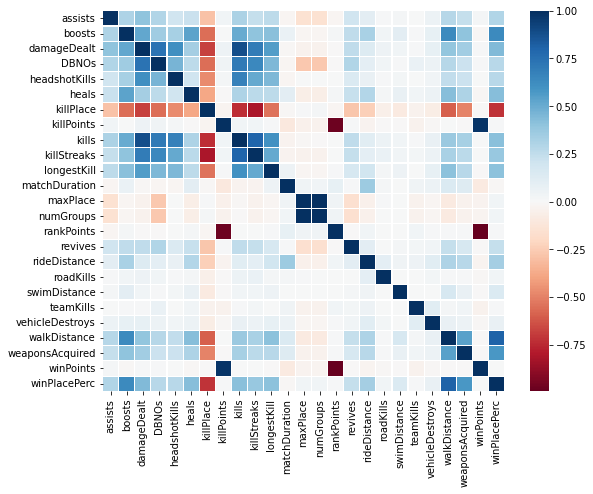

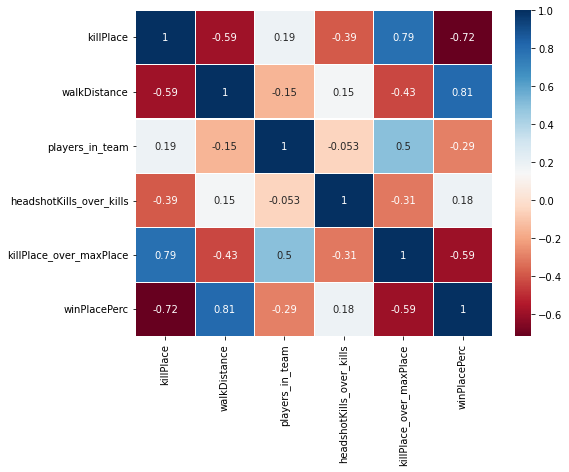

In [4]:
df = reload()

cols_to_drop = ['Id', 'groupId', 'matchId', 'matchType']
cols_to_fit = [col for col in df.columns if col not in cols_to_drop]
corr = df[cols_to_fit].corr()

plt.figure(figsize=(9,7))
sns.heatmap(
    corr,
    xticklabels=corr.columns.values,
    yticklabels=corr.columns.values,
    linecolor='white',
    linewidths=0.1,
    cmap="RdBu"
)
plt.show()

agg = df.groupby(['groupId']).size().to_frame('players_in_team')
df = df.merge(agg, how='left', on=['groupId'])
df['headshotKills_over_kills'] = df['headshotKills'] / df['kills']
df['headshotKills_over_kills'].fillna(0, inplace=True)
df['killPlace_over_maxPlace'] = df['killPlace'] / df['maxPlace']
df['killPlace_over_maxPlace'].fillna(0, inplace=True)
df['killPlace_over_maxPlace'].replace(np.inf, 0, inplace=True)
corr = df[['killPlace', 'walkDistance', 'players_in_team', 'headshotKills_over_kills', 'killPlace_over_maxPlace', 'winPlacePerc']].corr()

plt.figure(figsize=(8,6))
sns.heatmap(
    corr,
    xticklabels=corr.columns.values,
    yticklabels=corr.columns.values,
    annot=True,
    linecolor='white',
    linewidths=0.1,
    cmap="RdBu"
)
plt.show()

In [5]:
def train_test_split(df, test_size=0.1):
    match_ids = df['matchId'].unique().tolist()
    train_size = int(len(match_ids) * (1 - test_size))
    train_match_ids = random.sample(match_ids, train_size)

    train = df[df['matchId'].isin(train_match_ids)]
    test = df[-df['matchId'].isin(train_match_ids)]
    
    return train, test

In [6]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error

def run_experiment(preprocess):
    df = reload()
    df.drop(columns=['matchType'], inplace=True)
    
    df = preprocess(df)

    target = 'winPlacePerc'
    cols_to_drop = ['Id', 'groupId', 'matchId', target]
    cols_to_fit = [col for col in df.columns if col not in cols_to_drop]
    train, val = train_test_split(df, 0.1)
    
    model = LinearRegression()
    model.fit(train[cols_to_fit], train[target])
    
    y_true = val[target]
    y_pred = model.predict(val[cols_to_fit])
    return mean_absolute_error(y_true, y_pred)

def run_experiments(preprocesses):
    results = []
    for preprocess in preprocesses:
        start = time.time()
        score = run_experiment(preprocess)
        execution_time = time.time() - start
        results.append({
            'name': preprocess.__name__,
            'score': score,
            'execution time': f'{round(execution_time, 2)}s'
        })
        gc.collect()
        
    return pd.DataFrame(results, columns=['name', 'score', 'execution time']).sort_values(by='score')

In [7]:
def original(df):
    return df

def items(df):
    df['items'] = df['heals'] + df['boosts']
    return df

def players_in_team(df):
    agg = df.groupby(['groupId']).size().to_frame('players_in_team')
    return df.merge(agg, how='left', on=['groupId'])

def total_distance(df):
    df['total_distance'] = df['rideDistance'] + df['swimDistance'] + df['walkDistance']
    return df

def headshotKills_over_kills(df):
    df['headshotKills_over_kills'] = df['headshotKills'] / df['kills']
    df['headshotKills_over_kills'].fillna(0, inplace=True)
    return df

def killPlace_over_maxPlace(df):
    df['killPlace_over_maxPlace'] = df['killPlace'] / df['maxPlace']
    df['killPlace_over_maxPlace'].fillna(0, inplace=True)
    df['killPlace_over_maxPlace'].replace(np.inf, 0, inplace=True)
    return df

def walkDistance_over_heals(df):
    df['walkDistance_over_heals'] = df['walkDistance'] / df['heals']
    df['walkDistance_over_heals'].fillna(0, inplace=True)
    df['walkDistance_over_heals'].replace(np.inf, 0, inplace=True)
    return df

def walkDistance_over_kills(df):
    df['walkDistance_over_kills'] = df['walkDistance'] / df['kills']
    df['walkDistance_over_kills'].fillna(0, inplace=True)
    df['walkDistance_over_kills'].replace(np.inf, 0, inplace=True)
    return df

def teamwork(df):
    df['teamwork'] = df['assists'] + df['revives']
    return df

In [9]:
run_experiments([
    original,
    items,
    players_in_team,
    total_distance,
    headshotKills_over_kills,
    killPlace_over_maxPlace,
    walkDistance_over_heals,
    walkDistance_over_kills,
    teamwork
])

,name,score,execution time
4,headshotKills_over_kills,0.091597,27.18s
2,players_in_team,0.091758,50.87s
5,killPlace_over_maxPlace,0.091949,28.76s
7,walkDistance_over_kills,0.092258,28.06s
6,walkDistance_over_heals,0.092284,26.42s
0,original,0.092412,37.03s
1,items,0.092493,47.41s
8,teamwork,0.092811,28.24s
3,total_distance,0.092969,27.83s


In [10]:
def min_by_team(df):
    cols_to_drop = ['Id', 'groupId', 'matchId', 'winPlacePerc']
    features = [col for col in df.columns if col not in cols_to_drop]
    agg = df.groupby(['matchId','groupId'])[features].min()
    return df.merge(agg, suffixes=['', '_min'], how='left', on=['matchId', 'groupId'])

def max_by_team(df):
    cols_to_drop = ['Id', 'groupId', 'matchId', 'winPlacePerc']
    features = [col for col in df.columns if col not in cols_to_drop]
    agg = df.groupby(['matchId', 'groupId'])[features].max()
    return df.merge(agg, suffixes=['', '_max'], how='left', on=['matchId', 'groupId'])

def sum_by_team(df):
    cols_to_drop = ['Id', 'groupId', 'matchId', 'winPlacePerc']
    features = [col for col in df.columns if col not in cols_to_drop]
    agg = df.groupby(['matchId', 'groupId'])[features].sum()
    return df.merge(agg, suffixes=['', '_sum'], how='left', on=['matchId', 'groupId'])

def median_by_team(df):
    cols_to_drop = ['Id', 'groupId', 'matchId', 'winPlacePerc']
    features = [col for col in df.columns if col not in cols_to_drop]
    agg = df.groupby(['matchId', 'groupId'])[features].median()
    return df.merge(agg, suffixes=['', '_median'], how='left', on=['matchId', 'groupId'])

def mean_by_team(df):
    cols_to_drop = ['Id', 'groupId', 'matchId', 'winPlacePerc']
    features = [col for col in df.columns if col not in cols_to_drop]
    agg = df.groupby(['matchId', 'groupId'])[features].mean()
    return df.merge(agg, suffixes=['', '_mean'], how='left', on=['matchId', 'groupId'])

def rank_by_team(df):
    cols_to_drop = ['Id', 'groupId', 'matchId', 'winPlacePerc']
    features = [col for col in df.columns if col not in cols_to_drop]
    agg = df.groupby(['matchId', 'groupId'])[features].mean()
    agg = agg.groupby('matchId')[features].rank(pct=True)
    return df.merge(agg, suffixes=['', '_mean_rank'], how='left', on=['matchId', 'groupId'])

In [11]:
run_experiments([
    original,
    min_by_team,
    max_by_team,
    sum_by_team,
    median_by_team,
    mean_by_team,
    rank_by_team
])

,name,score,execution time
6,rank_by_team,0.057723,79.57s
4,median_by_team,0.076096,72.54s
5,mean_by_team,0.077007,72.45s
2,max_by_team,0.079271,80.88s
3,sum_by_team,0.087832,83.58s
1,min_by_team,0.089905,76.82s
0,original,0.092175,27.29s


[20]	valid_0's l1: 0.0648813
[40]	valid_0's l1: 0.0616004
[60]	valid_0's l1: 0.0604218
[80]	valid_0's l1: 0.0597163
[100]	valid_0's l1: 0.0593012


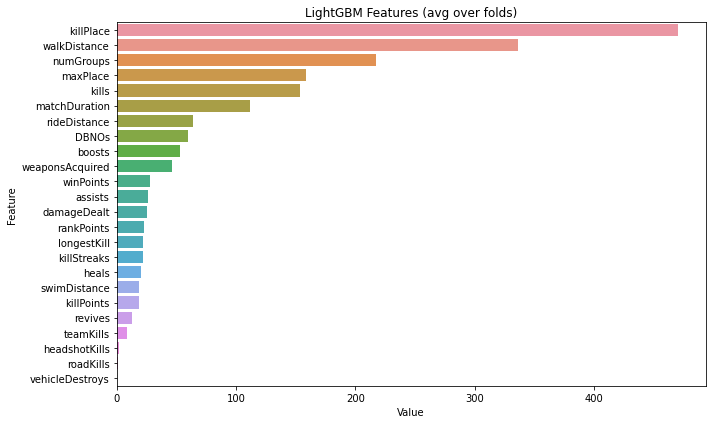

In [12]:
df = reload()

df.drop(columns=['matchType'], inplace=True)

target = 'winPlacePerc'
cols_to_drop = ['Id', 'groupId', 'matchId', 'matchType', target]
cols_to_fit = [col for col in df.columns if col not in cols_to_drop]
train, val = train_test_split(df, 0.1)

from lightgbm import LGBMRegressor # XGBoost 의 단점을 보완한 부스팅기법
params = {
    'n_estimators': 100,
    'learning_rate': 0.3, 
    'num_leaves': 20,
    'objective': 'regression_l2', 
    'metric': 'mae',
    'verbose': -1,
}

model = LGBMRegressor(**params)
model.fit(
    train[cols_to_fit], train[target],
    eval_set=[(val[cols_to_fit], val[target])],
    eval_metric='mae',
    verbose=20,
)

feature_importance = pd.DataFrame(sorted(zip(model.feature_importances_, cols_to_fit)), columns=['Value','Feature'])

plt.figure(figsize=(10, 6))
sns.barplot(x="Value", y="Feature", data=feature_importance.sort_values(by="Value", ascending=False))
plt.title('LightGBM Features (avg over folds)')
plt.tight_layout()

In [13]:
import eli5
from eli5.sklearn import PermutationImportance

perm = PermutationImportance(model, random_state=42).fit(val[cols_to_fit], val[target])
eli5.show_weights(perm, feature_names=list(cols_to_fit))

Weight,Feature
1.4651 ± 0.0048,killPlace
0.2952 ± 0.0010,walkDistance
0.2264 ± 0.0011,kills
0.0780 ± 0.0003,numGroups
0.0616 ± 0.0004,killStreaks
0.0544 ± 0.0002,maxPlace
0.0285 ± 0.0003,matchDuration
0.0076 ± 0.0001,boosts
0.0071 ± 0.0001,rideDistance
0.0038 ± 0.0001,weaponsAcquired


In [14]:
import shap
shap.initjs()

In [15]:
explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(val[cols_to_fit])

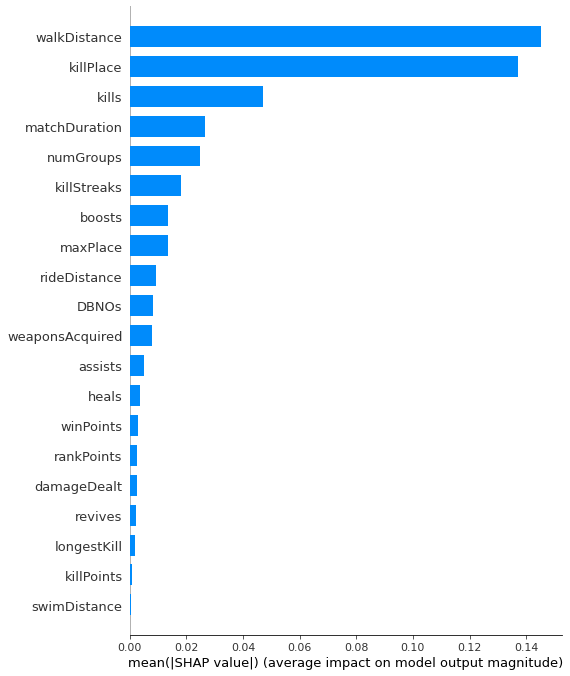

In [16]:
shap.summary_plot(shap_values, val[cols_to_fit], plot_type='bar')

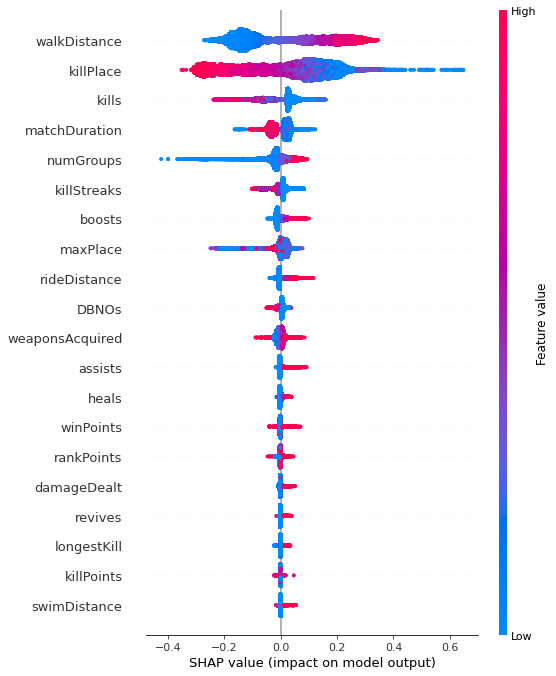

In [17]:
shap.summary_plot(shap_values, val[cols_to_fit], feature_names=cols_to_fit)

In [18]:
import gc